In [4]:
# Visualize Data and Analysis Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Pytorch to train data
import torch
from tqdm.notebook import tqdm
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

## 1. Load Data To Analysis


In [5]:
# Load data
df = pd.read_csv('./data/reviews.csv',  
                 low_memory=False)
df
# reset index
# df.set_index('Id', inplace=True)

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4
...,...,...,...
107013,107013,Trendy topic with talks from expertises in the...,4
107014,107014,"Wonderful! Simple and clear language, good ins...",5
107015,107015,an interesting and fun course. thanks. dr quincy,5
107016,107016,"very broad perspective, up to date information...",4


In [6]:
# # Rename columns to map to the original data
# df=df.rename(columns={'reviews': 'Text', 'rating': 'Score'})
# # Select only the columns we need
# df = df[['Text', 'Score']]
# # Add columns id for each score
# _dict_score = {0: 'Very Bad', 1: 'Bad', 2: 'Neutral', 3: 'Good', 4: 'Very Good'}
# _get_index = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
# # Add columns id for each score
# df['Id'] = df['Score']
# df['Id']=df['Id'].map(_get_index)
# df


In [7]:
df=df.rename(columns={'Review': 'Text', 'Label': 'Score'})

In [8]:
df.head()

,Id,Text,Score
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


Thông tin DataFrame:

- **Chỉ số (Index):** Range từ 0 đến 568453 (tổng cộng 568454 dòng).
- **Số cột:** 3 cột ("Id", "Score", "Text").
- **Kiểu dữ liệu cột:**
  - "Id" và "Score": int64.
  - "Text": object (chuỗi hoặc đối tượng không phải số).
- **Giá trị không phải null:**
  - Mỗi cột có 568454 giá trị không phải null.
- **Dung lượng bộ nhớ:** Khoảng 13.0 MB.

> 568454 - 568427 = 27 giá trị null

#### Lọc 512 token cho Bert

In [9]:
df = df[df['Text'].apply(lambda x: len(str(x)) < 512)]

In [10]:
# Info Data:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102869 entries, 0 to 107017
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      102869 non-null  int64 
 1   Text    102869 non-null  object
 2   Score   102869 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.1+ MB


- `df`: Đây là tên của DataFrame, giả sử đã được định nghĩa trước đó trong mã.

- `df.Text`: Lấy cột có tên "Text" từ DataFrame `df`.

- `.iloc[10]`: Lấy giá trị ở dòng thứ 10 của cột "Text".

In [11]:
# Check for null:
df.Text.iloc[10]

"Is there any reason why you should not apply the course by BCG?)It's content is pretty unique and includes a high level analysis and a wide range of knowledge needed to cover all detailed aspects.Best regards,Oleg Serov"

In [12]:
# check for null
df.isnull().sum()

Id       0
Text     0
Score    0
dtype: int64

> Xử lý xong các giá trị null, nếu có

In [13]:
# delete null values
# Xóa các dòng có giá trị null
df = df.dropna(subset=['Text'])
# check for null
df.isnull().sum()
# Info Data:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102869 entries, 0 to 107017
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      102869 non-null  int64 
 1   Text    102869 non-null  object
 2   Score   102869 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.1+ MB


In [14]:
df.Score.value_counts()

Score
5    77203
4    17192
3     4548
1     2065
2     1861
Name: count, dtype: int64

In [15]:
# # Reduce data:
# indices_to_remove = df[df['Score'] == 1].index[1:40000]
# df = df.drop(indices_to_remove)
# # Reduce data:
# indices_to_remove = df[df['Score'] == 2].index[1:20000]
# df = df.drop(indices_to_remove)
# # Reduce data:
# indices_to_remove = df[df['Score'] == 3].index[1:30000]
# df = df.drop(indices_to_remove)
# # Reduce data:
# indices_to_remove = df[df['Score'] == 4].index[1:70000]
# df = df.drop(indices_to_remove)
# # Reduce data:
# indices_to_remove = df[df['Score'] == 5].index[1:350000]
# df = df.drop(indices_to_remove)
# df.Score.value_counts()
# df.info()

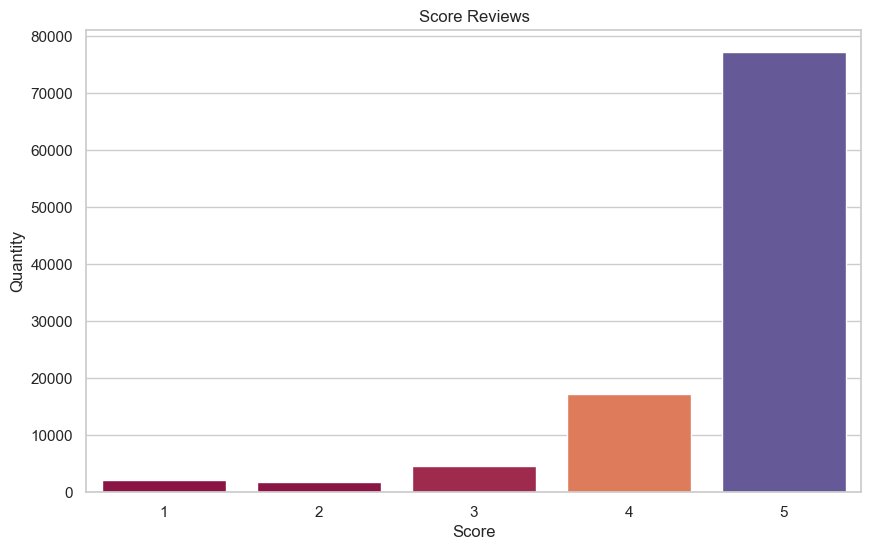

In [16]:
# Lấy Series từ df['Score'].value_counts()
score_counts = df['Score'].value_counts()

# Thiết lập môi trường trực quan
sns.set(style="whitegrid", palette="pastel")

# Vẽ biểu đồ thanh
plt.figure(figsize=(10, 6))
sns.barplot(x=score_counts.index, y=score_counts.values,
            palette="Spectral", legend=False, hue=score_counts.values)
plt.title('Score Reviews')
plt.xlabel('Score')
plt.ylabel('Quantity')
plt.show()

In [17]:
# find the maximum length
max_len = max([len(text) for text in df.Text])
print('Max length: ', max_len)

Max length:  511


## 2. Spliting into Train, Test, Val


1. **`from sklearn.model_selection import train_test_split`**: 
   - Nhập hàm `train_test_split` từ scikit-learn để thực hiện chia dữ liệu thành tập huấn luyện và tập kiểm tra.

2. **`X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.Score.values, test_size=0.15, random_state=17, stratify=df.Score.values)`**:
   - `df.index.values`: Chọn cột chỉ mục của DataFrame (`index`), giả sử rằng nó chứa các giá trị duy nhất hoặc độc lập.
   - `df.Score.values`: Chọn cột "Score" làm giá trị mục tiêu.
   - `test_size=0.15`: Thiết lập tỷ lệ tập kiểm tra là 15%, tỷ lệ tập huấn luyện là 85%.
   - `random_state=17`: Đặt một giá trị ngẫu nhiên để đảm bảo tái tạo kết quả nếu bạn muốn chạy lại mã và nhận được kết quả giống nhau.
   - `stratify=df.Score.values`: Thiết lập để đảm bảo phân phối của tập kiểm tra giữ nguyên tỷ lệ của các lớp (stratified sampling), đặc biệt quan trọng nếu dữ liệu không cân bằng theo các giá trị của "Score".

3. **`X_train, X_val, y_train, y_val`**:
   - `X_train`, `X_val`: Chứa các chỉ mục (index) của dữ liệu tương ứng trong tập huấn luyện và tập kiểm tra.
   - `y_train`, `y_val`: Chứa các giá trị "Score" tương ứng với tập huấn luyện và tập kiểm tra.

Tổng cộng, đoạn mã này chia dữ liệu thành tập huấn luyện và tập kiểm tra, sử dụng 85% dữ liệu cho tập huấn luyện và 15% cho tập kiểm tra, và giữ nguyên tỷ lệ của các lớp trong quá trình chia dữ liệu. Điều này làm cho mô hình có thể học từ một phân phối dữ liệu tương tự như dữ liệu gốc.

In [18]:
from sklearn.model_selection import train_test_split

# train test split
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.Score.values,
                                                  test_size=0.15,
                                                  random_state=17,
                                                  stratify=df.Score.values)
# create new column
df['data_type'] = ['not_set'] * df.shape[0]
df.head()

,Id,Text,Score,data_type
0,0,good and interesting,5,not_set
1,1,"This class is very helpful to me. Currently, I...",5,not_set
2,2,like!Prof and TAs are helpful and the discussi...,5,not_set
3,3,Easy to follow and includes a lot basic and im...,5,not_set
4,4,Really nice teacher!I could got the point eazl...,4,not_set


In [19]:
# fill in data type
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'


In [20]:
df.groupby(['Score','data_type']).count()

Id   Text
Score data_type              
1     train       1755   1755
      val          310    310
2     train       1582   1582
      val          279    279
3     train       3866   3866
      val          682    682
4     train      14613  14613
      val         2579   2579
5     train      65622  65622
      val        11581  11581

## 3. Data Preprocessing



1. **`from transformers import BertTokenizer`**:
   - `BertTokenizer` là một lớp từ thư viện Transformers của Hugging Face, được thiết kế để chuyển đổi văn bản thành đầu vào mà mô hình BERT có thể hiểu được. Nó cung cấp các phương thức để mã hóa văn bản thành các token và thêm các thông tin đặc biệt như token đặc biệt `[CLS]` và `[SEP]` sử dụng trong mô hình BERT.

2. **`from torch.utils.data import TensorDataset`**:
   - `TensorDataset` là một lớp từ thư viện torch, được sử dụng để tạo dataset cho PyTorch. Đây là một cách thuận tiện để tổ chức dữ liệu và truyền nó vào mô hình PyTorch. Lớp này chấp nhận một hoặc nhiều tensors và tạo ra một dataset với khả năng lập chỉ mục dữ liệu.



In [21]:
from transformers import BertTokenizer, AutoTokenizer
from torch.utils.data import TensorDataset

In [22]:
# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [23]:
max_len_text = max(len(text) for text in df.Text)
max_len_text

511

### Giải pháp cho text dài vì tokenize bert chỉ 512 token.

In [35]:
# Mã hóa dữ liệu cho từng giới hạn của text
def encode_long_sequences(texts, max_len_text, tokenizer, data_type):
    encoded_data = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True if data_type=='train' else False,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=max_len_text+1,
        return_token_type_ids=False,
        return_tensors='pt',
    )
    return encoded_data

def encode_texts(df, data_type, max_len_text, tokenizer):
    texts = df[df.data_type == data_type].Text.values
    encoded_data = []

    max_segment_len = max_len_text  # Tối đa 512 tokens cho mỗi segment

    for text in texts:
        text_segments = [text[i:i + max_segment_len] for i in range(0, len(text), max_segment_len)]
        encoded_segments = encode_long_sequences(text_segments, max_segment_len, tokenizer, data_type)
        encoded_data.append(encoded_segments)

    merged_data = {}
    for key in encoded_data[0].keys():
        merged_data[key] = torch.cat([item[key] for item in encoded_data], dim=0)

    return merged_data

# encode train data
encoded_train_data = encode_texts(df, 'train', 510, tokenizer) # 510 tokens cho mỗi segment


In [ ]:
# # tokenize train set
# encoded_train_data = tokenizer.batch_encode_plus(df[df.data_type == 'train'].Text.values,
#                                                  add_special_tokens=True,
#                                                  return_attention_mask=True,
#                                                  pad_to_max_length=True,
#                                                  max_length=max_len_text+1,
#                                                  return_tensors='pt',)


c:\Work_Space\ML\final_project\Mashine-Learning---RoBerta---Base-Bert\venv390\lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# # tokenizer val set
# encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].Text.values,
#                                                # add_special_tokens = True,
#                                                return_attention_mask=True,
#                                                pad_to_max_length=True,
#                                                max_length=max_len_text+1,
#                                                return_tensors='pt')

In [ ]:
# tokenizer val set
encoded_val_data = encode_texts(df, 'val', 510, tokenizer) # 510 tokens cho mỗi segment

In [ ]:
encoded_train_data

{'input_ids': tensor([[  101,  2204,  1998,  ...,     0,     0,     0],
         [  101,  2023,  2465,  ...,     0,     0,     0],
         [  101,  2066,   999,  ...,     0,     0,     0],
         ...,
         [  101,  2019,  5875,  ...,     0,     0,     0],
         [  101,  2200,  5041,  ...,     0,     0,     0],
         [  101,  2019, 12367,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

## 4. Encoding

In [36]:
# encode train set
input_ids_train = encoded_train_data['input_ids']
attention_masks_train = encoded_train_data['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].Score.values)

In [37]:
# encode val set
input_ids_val = encoded_val_data['input_ids']
attention_masks_val = encoded_val_data['attention_mask']

# convert data type to torch.tensor
labels_val = torch.tensor(df[df.data_type == 'val'].Score.values)

NameError: name 'encoded_val_data' is not defined

In [50]:
input_ids_train.shape

torch.Size([87459, 511])

In [39]:
attention_masks_train.shape

torch.Size([87459, 511])

In [40]:
labels_train.shape

torch.Size([87438])

In [ ]:
# create dataloader
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val,
                            attention_masks_val,
                            labels_val)

AssertionError: Size mismatch between tensors

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

87438
15431


In [ ]:
dataset_train.__str__()

'<torch.utils.data.dataset.TensorDataset object at 0x000001CC08599790>'

In [ ]:
dataset_train.tensors

(tensor([[  101,  2204,  1998,  ...,     0,     0,     0],
         [  101,  2023,  2465,  ...,     0,     0,     0],
         [  101,  2066,   999,  ...,     0,     0,     0],
         ...,
         [  101,  2019,  5875,  ...,     0,     0,     0],
         [  101,  2200,  5041,  ...,     0,     0,     0],
         [  101,  2019, 12367,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([5, 5, 5,  ..., 5, 4, 4]))

## 5. Setting up BERT Pretrained Model

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(df.Score.unique()),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## 6. Creating Data Loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 32

# We Need two different dataloder
dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size,
                              num_workers=1,
                                pin_memory=True

                              )

dataloader_validation = DataLoader(dataset_val,
                                   sampler=RandomSampler(dataset_val),
                                   batch_size=batch_size,
                                   num_workers=1,
                                   pin_memory=True
                                   )

In [ ]:
dataloader_train.__len__()

2733

## 7. Setting Up Optimiser and Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

c:\Work_Space\ML\final_project\Mashine-Learning---RoBerta---Base-Bert\venv390\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## 8. Defining our Performance Metrics

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

In [ ]:
def f1_score_func(preds, labels):

    # Setting up the preds to axis=1
    # Flatting it to a single iterable list of array
    preds_flat = np.argmax(preds, axis=1).flatten()

    # Flattening the labels
    labels_flat = labels.flatten()

    # Returning the f1_score as define by sklearn
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
label_dict = {0: 'Very Bad', 1: 'Bad', 2: 'Neutral', 3: 'Good', 4: 'Very Good'}

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Iterating over all the unique labels
    # label_flat are the --> True labels
    for label in np.unique(labels_flat):
        # Taking out all the pred_flat where the True alable is the lable we care about.
        # e.g. for the label Happy -- we Takes all Prediction for true happy flag
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}\n')

## 9. Create a training loop to control PyTorch finetuning of BERT using CPU or GPU acceleration

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 6.70 GiB is allocated by PyTorch, and 69.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def evaluate(dataloader_val, model=model):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                  }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
# Messure step:


In [ ]:
for epoch in range(1, epochs+1):
    # Set model in train mode

    model.train()

    # Tracking variable
    loss_train_total = 0
    print(f'Epoch {epoch}')
    # set up progress bar
    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)
    for batch in progress_bar:
        # Set gradient to 0
        model.zero_grad()
        # Load into GPU
        batch = tuple(b.to(device) for b in batch)
        # Define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        outputs = model(**inputs)
        loss = outputs[0]  # output.loss
        loss_train_total += loss.item()
        # Backward pass to get gradients
        loss.backward()
        # Clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update optimizer
        optimizer.step()
        # Update scheduler

        scheduler.step()
        print(f'Training loss: {loss.item()/len(batch)}')
        # break



    model_save_path = f'./model/pretrained_bert_model_{epoch}.pt'

    torch.save(model, model_save_path)


    # Print training result
    loss_train_avg = loss_train_total/len(dataloader_train)

    print(f'Training loss: {loss_train_avg}')
    # Evaluate
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    # F1 score
    val_f1 = f1_score_func(predictions, true_vals)
    print(f'Validation loss: {val_loss}')
    print(f'F1 Score (weighted): {val_f1}')

Epoch 1


Epoch 1:   0%|          | 0/2733 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 6.45 GiB is allocated by PyTorch, and 55.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 10. Model Evaluation

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Đường dẫn đến tệp .pt đã lưu
model_path = '../model/pretrained_bert_model_1.pt'

# Khởi tạo mô hình BERT cho phân loại chuỗi và tải trạng thái từ tệp đã lưu
load_model = torch.load(model_path)

load_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
#evaluate
_, predictions, true_vals = evaluate(dataloader_validation, load_model)

  0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
#get accuracy score
accuracy_per_class(predictions, true_vals)

Class: so sad
Accuracy: 212/340

Class: sad
Accuracy: 82/337

Class: worry
Accuracy: 195/396

Class: happy
Accuracy: 216/398

Class: so happy
Accuracy: 195/319

